# Multi-center analysis

### Imports

In [ ]:
import sys
sys.path.append('../')
from PAINTeR import connectivity # in-house lib used for the RPN-signature
from PAINTeR import plot # in-house lib used for the RPN-signature
from PAINTeR import model # in-house lib used for the RPN-signature
import numpy as np # hi old friend
import pandas as pd

from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure

from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold, GroupKFold, LeavePGroupsOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

### Processing parameters

In [342]:
thres_mean_FD = 0.15 # mm
scrub_threshold = 0.15 # mm
thres_perc_scrub = 30 # % scubbed out

### Load all behavioral data

In [343]:
# load bochum data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()

study
bochum    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
essen     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
szeged    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

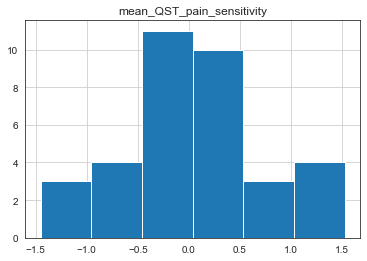

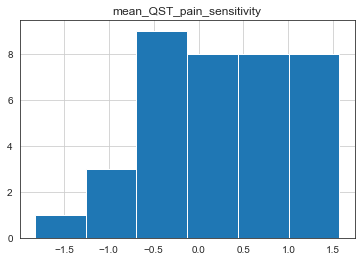

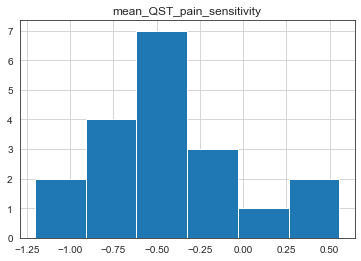

In [344]:
df.groupby('study').hist('mean_QST_pain_sensitivity', bins=6)

### Load standardized scrubbed timeseries

In [345]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'
    
    ts = pd.read_csv(f_scrub).iloc[:,1:] # here we can omit global signal...
    
    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd 
    
    perc_scrubbed.append(100 - 100*len(ts.shape)/len(fd) )
    timeseries.append(ts.values)
    

In [346]:
#region names
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")

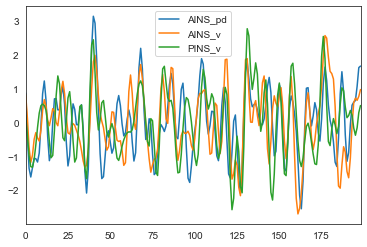

In [347]:
# plot a specific timeseries
sub_idx=10
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()

### Calculate connectivity

In [348]:
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag

In [349]:
# 3d plot in browser window
#coords = plotting.find_parcellation_cut_coords("../data/atlas_relabeled.nii.gz")
#view = plotting.view_connectome(mat, coords)
#view.open_in_browser()

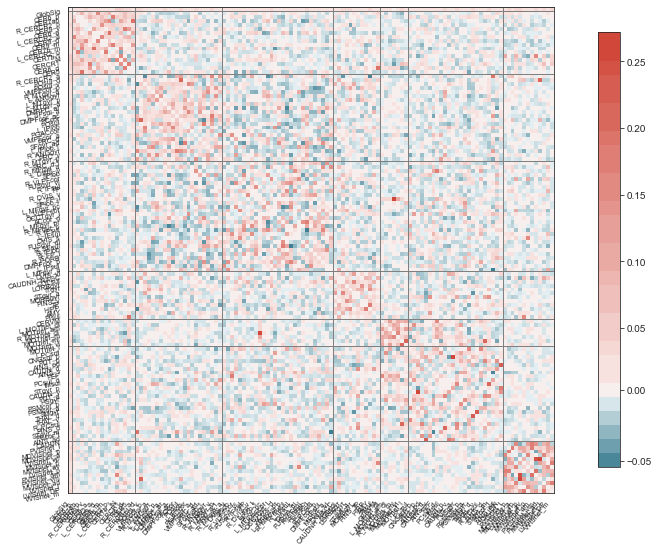

In [350]:
plot.plot_matrix(mat, labels, modules)

In [351]:
y = df.mean_QST_pain_sensitivity

(91, 7503) 91


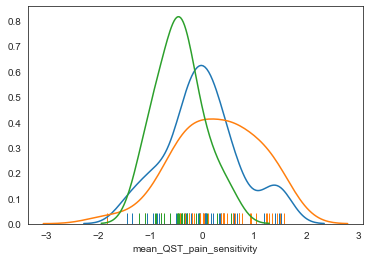

In [357]:
sns.distplot(y[df.study=='bochum'], hist=False, rug=True)
sns.distplot(y[df.study=='essen'], hist=False, rug=True)
sns.distplot(y[df.study=='szeged'], hist=False, rug=True)
print(X.shape, len(y))

### Group data to get balanced splits in a 30-fold cross-validation

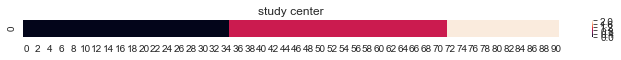

35 37 19


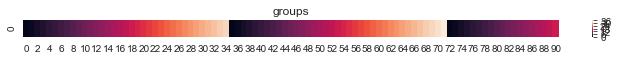

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18])

In [402]:
plt.figure(figsize=(12, 0.3))
sns.heatmap([df.study.astype("category").cat.codes.values]).set_title('study center')
plt.show()
n_szeged = np.sum(df.study == 'szeged') # size of the smallest study
n_essen = np.sum(df.study == 'essen')
n_bochum = np.sum(df.study == 'bochum')
print(n_bochum, n_essen, n_szeged)

groups=np.zeros(len(df), dtype=int)

g=0
i=0
while i < n_bochum:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
    
g=0
i=n_bochum
while i < n_bochum+n_essen:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
g=0
i=n_bochum+n_essen
while i < len(df):
    groups[i] = g
    i += 1
    g += 1
    
plt.figure(figsize=(12, 0.3))
sns.heatmap([groups]).set_title('groups')
plt.show()

groups

## Model training - non nested

Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.0s finished


**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 2000, 'model__alpha': 0.01, 'model__l1_ratio': 0.999}
** Score on full data as training set:	-0.0034061816882288527
** Score on mean as model: -0.5655535039999882
** Best Non-nested cross-validated score on test:	-0.2819469500871076
XXXXX Explained Variance: 0.5014672385672047


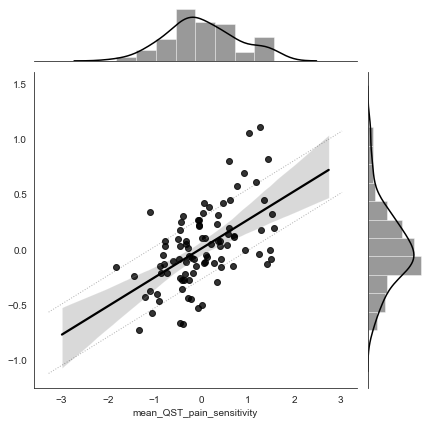

In [430]:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          #p_grid = {'fsel__k': [50, 100, 500, 700, 1000, 2000, 5000, 'all'], 'model__alpha': [.001, .005, .01, .05, .1, .5], 'model__l1_ratio': [0.001, .1, .5, .7, .9, .999]
                          p_grid = {'fsel__k': [2000], 'model__alpha': [.01], 'model__l1_ratio': [.999]
         
                                   }):
                 
                        
    mymodel = Pipeline(
        [('scaler', scaler),
         ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid

model, p_grid = pipe_scale_fsel_elnet()

cv = GroupKFold(30)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)
clf.fit(X, y, groups=groups)
print("**** Non-nested analysis ****")
print("** Best hyperparameters: " + str(clf.best_params_))

print("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=y)))
print("** Score on mean as model: " + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))
print("XXXXX Explained Variance: " + str(
        1 - clf.best_score_ / -mean_squared_error(np.repeat(y.mean(), len(y)), y)))


cv_pred = cross_val_predict(clf.best_estimator_, X, y, cv=cv, groups=groups, n_jobs=-1)                                 
plot.plot_prediction(y, predicted, sd=True, covar=[])

#for train_index, test_index in group_kfold.split(X, y, groups):
#    #print("TRAIN:", train_index, "TEST:", test_index)
#    #print(df.study[train_index].values)
#    print('test:', df.study[test_index].values)

## Model training - nested

In [ ]:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid = {'fsel__k': [10, 50, 100, 200, 500, 700, 1000, 2000, 3000, 4000, 5000, 'all'], 'model__alpha': [.001, .01, .1, 1, 10], 'model__l1_ratio': [0.001, .1, .3, .5, .7, .9, .999] 
                          #p_grid = {'fsel__k': [1000, 2000, 5000], 'model__alpha': [.001, .005, .01, .05, .1], 'model__l1_ratio': [.999]
                        }):
    mymodel = Pipeline(
        [('scaler', scaler),
         ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid

model, p_grid = pipe_scale_fsel_elnet()

outer_cv = GroupKFold(30)
inner_cv = GroupKFold(30)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=groups):
    group_train = groups[train]                                
    clf.fit(X[train], y[train], groups=group_train)
                                    
    print(str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1
                                    
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

model	inner_cv mean score	outer vc score
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 61.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 4000, 'model__alpha': 0.01, 'model__l1_ratio': 0.7} -0.3567046503631574 -0.17657717111907056
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.999} -0.3757451695980207 -0.06919510060887223
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 41.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 2000, 'model__alpha': 0.01, 'model__l1_ratio': 0.7} -0.3864883317210707 -0.10802311080824012
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 55.5min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.7} -0.28049247428055096 -0.2283162488061812
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 'all', 'model__alpha': 0.001, 'model__l1_ratio': 0.999} -0.3060372589798621 -0.10548271232592828
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9} -0.3150640301042447 -0.39869141477509334
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.5} -0.3137721347685469 -0.12473569352687293
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 'all', 'model__alpha': 0.01, 'model__l1_ratio': 0.999} -0.3409820714815736 -0.13368854496728538
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 56.0min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'fsel__k': 700, 'model__alpha': 0.01, 'model__l1_ratio': 0.7} -0.37523114215674996 -0.05981527091642865
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 57.3min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 108.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks      

{'fsel__k': 4000, 'model__alpha': 0.001, 'model__l1_ratio': 0.999} -0.31601053292175235 -0.23805894794455176
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 66.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 102.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 154.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks     

{'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.999} -0.36993643888989397 -0.6131724189031885
Fitting 30 folds for each of 420 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 48.3min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 64.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 88.7min


*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.4213646506581069
** Mean Nested Crossvalidation Score (outer_cv):	-0.39838520258572474
Explained Variance: 0.295583530527055
Correlation: 0.5557563502360584


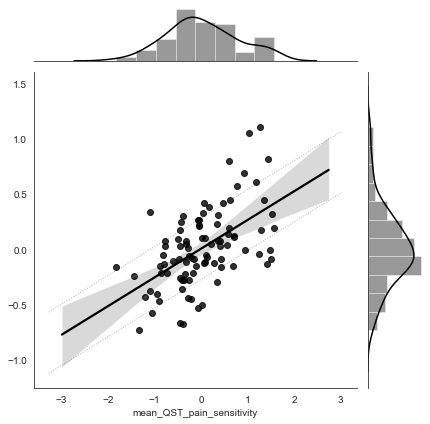

In [428]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

## Finalize and save model

## Obtain predictive network and compare to the RPN-signature